In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import time
from datetime import timedelta
import cv2

# Importing the datasets 

In [2]:
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train,
    y_train,
    
    test_size=0.2,
    random_state=832289)

# this is a tiny training set to practice overfitting 
X_tiny = X_train[9998:10007]
y_tiny = y_train[9998:10007]

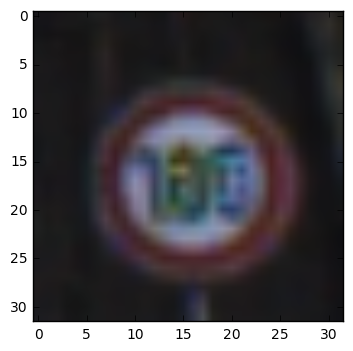

In [3]:
plt.imshow(X_tiny[2])

In [4]:
y_tiny[2]

7

In [5]:
len(X_test)

12630

## Dataset facts 

In [6]:
n_train = len(y_train)
n_validation = len(y_validation)
n_test = len(y_test)
image_shape  = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

img_size_flat = image_shape[0] * image_shape[1]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Image Size Flat =", img_size_flat)

Number of training examples = 31367
Number of validation examples = 7842
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image Size Flat = 1024


# One-hot encoding the labels

In [7]:
y_train_encoded = np.eye(43)[y_tiny]
y_test_encoded = np.eye(43)[y_tiny]

# y_train_encoded = np.eye(43)[y_train]
# y_test_encoded = np.eye(43)[y_test]

In [8]:
image_shape[0]

32

In [9]:
np.mean(X_train)

82.738805640847332

# Pre-processing the images


In [10]:
def pre_process_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32,32),interpolation = cv2.INTER_CUBIC)
    
#     Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    image = a + ((image - Xmin) * (b-a)) / (Xmax-Xmin)
#     image = image - np.mean(X_train)
    return image

In [11]:
image_GS_train = np.array([pre_process_image(X_tiny[i]) for i in range(len(X_tiny))], dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_tiny[i]) for i in range(len(X_tiny))], dtype = np.float32)

# image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
# image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype = np.float32)

In [12]:
image_flat_train = image_GS_train.reshape((-1,img_size_flat))
image_flat_test  = image_GS_test.reshape((-1,img_size_flat))

In [13]:
def process_and_flatten(image_array):
    images_gray = np.array([pre_process_image(image_array[i]) for i in range(len(image_array))], dtype = np.float32)
    images_flat= images_gray.reshape((-1,img_size_flat))
#         Min-Max scaling for greyscale image data
    Xmin = 0
    Xmax = 255
    a = 0.1
    b = 0.9
    
    images_new = a + ((images_flat - Xmin) * (b-a)) / (Xmax-Xmin)
    return images_new

In [14]:
(image_flat_train[0]) 

array([ 0.89999998,  0.89999998,  0.89999998, ...,  0.89999998,
        0.89999998,  0.89999998], dtype=float32)

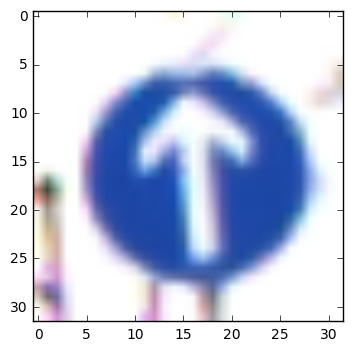

In [15]:
plt.imshow(X_tiny[0])

# Batching

In [16]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(image_flat_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = image_flat_train[idx, :]
    labels_batch = y_train_encoded[idx, :]

    return features_batch, labels_batch

# Configuring the Neural Network


In [17]:
# Convolutional Layer 1.
filter_size1 = 4       # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 4          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Fully-connected layer.
fc_size = 128 

## Some helper functions for convolutional layer generation


In [18]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))


In [19]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [20]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [21]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

# Setting up the TensorFlow model

## setting up the placeholder variables

# TensorFlow model

In [51]:

img_size = 32
num_channels = 1
num_classes = 43
learning_rate = 1e-3
batch_size = 9
keep_prob = 0.9

x = tf.placeholder(tf.float32, [None, img_size_flat])
y = tf.placeholder(tf.float32, [None, n_classes])

# sets up a place for the non one-hot classes to go
y_true_cls = tf.placeholder(tf.int64, [None])

# thhis is putting the images back into the 4 dimensional format for the convo layers
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

# convolutinal layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

# convolutinal layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

# flatten Layer 
layer_flat, num_features = flatten_layer(layer_conv2)

# fully connected layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)



# fully connected layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

layer_fc2 = tf.nn.dropout(layer_fc2, keep_prob)

y_pred = tf.nn.softmax(layer_fc2)

y_pred_cls = tf.argmax(y_pred, dimension = 1)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(layer_fc2, y))

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)


correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# TensorFlow Session


In [52]:

def optimize(n_iterations):
    accuracy_list = []
    loss_list = []
    iteration_list = []
    
    for iteration in range(n_iterations):
        features_batch, labels_true_batch = random_batch()
        feed_dict_batch = {x: features_batch, y: labels_true_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)
        
        feed_dict_test = {x: image_flat_test,
                  y: y_test_encoded,
                  y_true_cls:y_tiny}
        
        
        acc = sess.run(accuracy,feed_dict=feed_dict_test)
#         print(acc)
        accuracy_list.append(acc)
        loss = sess.run(cost,feed_dict=feed_dict_test)
#         print(loss)
        loss_list.append(loss)
        iteration_list.append(iteration)
        

    loss_plot = plt.subplot(211)
    loss_plot.set_title('Loss & Accuracy')
    loss_plot.plot(iteration_list, loss_list, 'g')
    acc_plot = loss_plot.twinx()
    acc_plot.plot(iteration_list, accuracy_list, 'b')
        
    
        

In [53]:
# sess = tf.Session()
sess= tf.Session(config=tf.ConfigProto(log_device_placement=True))


compute time:  0:00:02


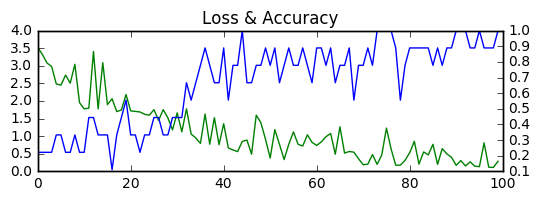

In [54]:
start_time = time.time()
sess.run(tf.initialize_all_variables())

optimize(100)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))

## Getting the accuracy on the Test Set

In [26]:
feed_dict_test = {x: image_flat_test,
                  y: y_test_encoded,
                  y_true_cls:y_tiny}


# feed_dict_test = {x: image_flat_test,
#                   y: y_test_encoded,
#                   y_true_cls:y_test}

In [27]:

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print(acc)
    

0.666667


In [28]:
feed_dict = {x: image_flat_test[0:9]}
classification = sess.run(y_pred, feed_dict)
cls_pred = np.argmax(classification, axis=1)
print(cls_pred)

[35 32  7  2 38 35  7 10  2]


In [29]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    #create figure with 3x3 sub-plots
    fig, axes = plt.subplots(3,3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        #plot image
        ax.imshow(images[i].reshape(32,32),  cmap='Greys_r')
        
        # show true and predicted classes
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        ax.set_xlabel(xlabel)
        
        # remove ticks from the plot 
        ax.set_xticks([])
        ax.set_yticks([])

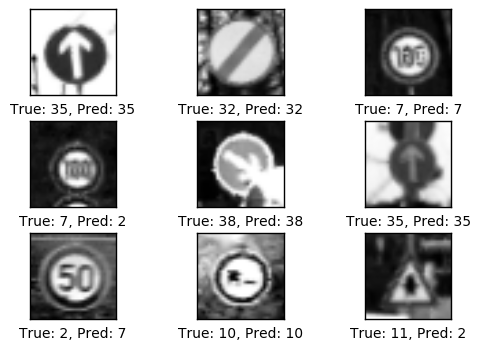

In [30]:
images = image_flat_test[0:9]
cls_true = y_tiny[0:9]
plot_images(images = images, cls_true = cls_true, cls_pred = cls_pred)


# Predicting the class for one image

helpful source: http://stackoverflow.com/questions/33711556/making-predictions-with-a-tensorflow-model

In [31]:
image_flat_train[0]

array([ 0.89999998,  0.89999998,  0.89999998, ...,  0.89999998,
        0.89999998,  0.89999998], dtype=float32)

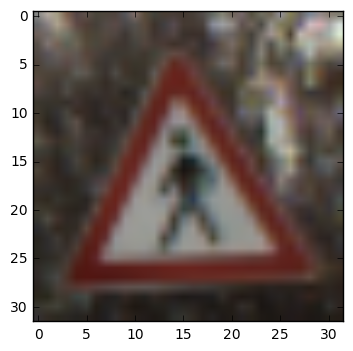

In [32]:
plt.imshow(X_test[10000])

In [33]:
y_test[10000]

27

In [34]:
feed_dict = {x: image_flat_test[0:9]}
classification = sess.run(y_pred, feed_dict)
cls = np.argmax(classification, axis=1)
print(cls)

[35 32  7  7 38 35  7 10 11]


In [63]:
a = classification[0]
np.amax(a)

0.77555478

IndexError: index 6 is out of bounds for axis 0 with size 6

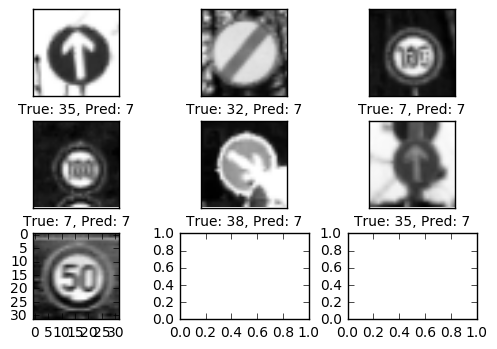

In [60]:
images =image_flat_test[0:9]
cls_true = y_tiny[0:9]
plot_images(images = images, cls_true = cls_true, cls_pred = cls)

In [36]:
import os, glob

new_signs= list()

path = "/home/deep_cat/traffic-signs-tensorflow/new_test_images"
test = os.path.join(path, '*.jpg')
print(test)

for infile in glob.glob(os.path.join(path, '*.jpg')):
    print(infile)
    img = cv2.imread(infile)
    arr1 = np.array(img)
    resize_img = cv2.resize(arr1, (32,32))
    new_signs.append(resize_img)
print(np.shape(new_signs))

/home/deep_cat/traffic-signs-tensorflow/new_test_images/*.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381023.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381275.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/465921877.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381095.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/469763307.jpg
/home/deep_cat/traffic-signs-tensorflow/new_test_images/459381273.jpg
(6, 32, 32, 3)


In [37]:
new_signs = np.array(new_signs)

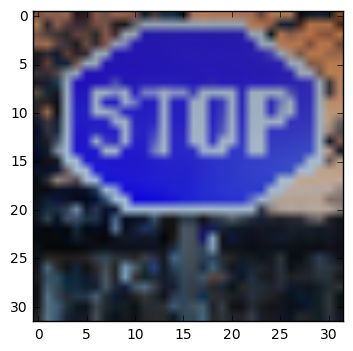

In [38]:
plt.imshow(new_signs[5])

In [39]:
new_signs_flat = process_and_flatten(new_signs)

In [40]:
new_signs_flat

array([[ 0.10142592,  0.10143576,  0.10143576, ...,  0.10054994,
         0.10139639,  0.10054994],
       [ 0.10134718,  0.10138655,  0.10140623, ...,  0.10179993,
         0.10165229,  0.10189835],
       [ 0.10106175,  0.10094364,  0.10076647, ...,  0.10115033,
         0.10098301,  0.10119954],
       [ 0.10056963,  0.10044168,  0.10053026, ...,  0.10066805,
         0.10066805,  0.1005401 ],
       [ 0.10152434,  0.10172118,  0.10145544, ...,  0.10057947,
         0.10053026,  0.10063852],
       [ 0.10108143,  0.10127828,  0.10122906, ...,  0.10061884,
         0.10083538,  0.10058931]], dtype=float32)

In [41]:
feed_dict = {x: new_signs_flat}
classification = sess.run(y_pred, feed_dict)

cls = np.argmax(classification, axis=1)
print(cls)


[7 7 7 7 7 7]


In [42]:
print(classification[0])

[  5.47659511e-06   1.49231473e-05   2.04698622e-01   2.12087743e-05
   4.83335243e-05   1.11644995e-05   4.28826752e-05   7.75554776e-01
   1.60054678e-05   1.40261272e-05   1.78753340e-03   1.78753340e-03
   6.31004241e-06   1.83787142e-05   9.30447277e-05   1.36020835e-05
   2.77239942e-05   2.92834939e-05   1.34412048e-05   5.01010400e-05
   5.12183724e-05   3.08590861e-05   3.71412498e-05   1.73899007e-05
   1.72648088e-05   7.91091734e-05   2.09758218e-05   3.27821654e-05
   7.66439825e-06   1.12931411e-05   2.34827130e-05   1.45930453e-05
   9.04683396e-03   1.78753340e-03   5.14178573e-05   5.98264916e-04
   8.16123156e-06   3.45762273e-05   2.05945433e-03   1.61821699e-05
   1.78753340e-03   8.07684955e-06   3.88309854e-06]
